# Temporal-Difference Methods

Implementations of many Temporal-Difference (TD) methods.

---

### Explore CliffWalkingEnv

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)  # actions
print(env.observation_space)  # states

Discrete(4)
Discrete(48)


Visualise the optimal state-value function.

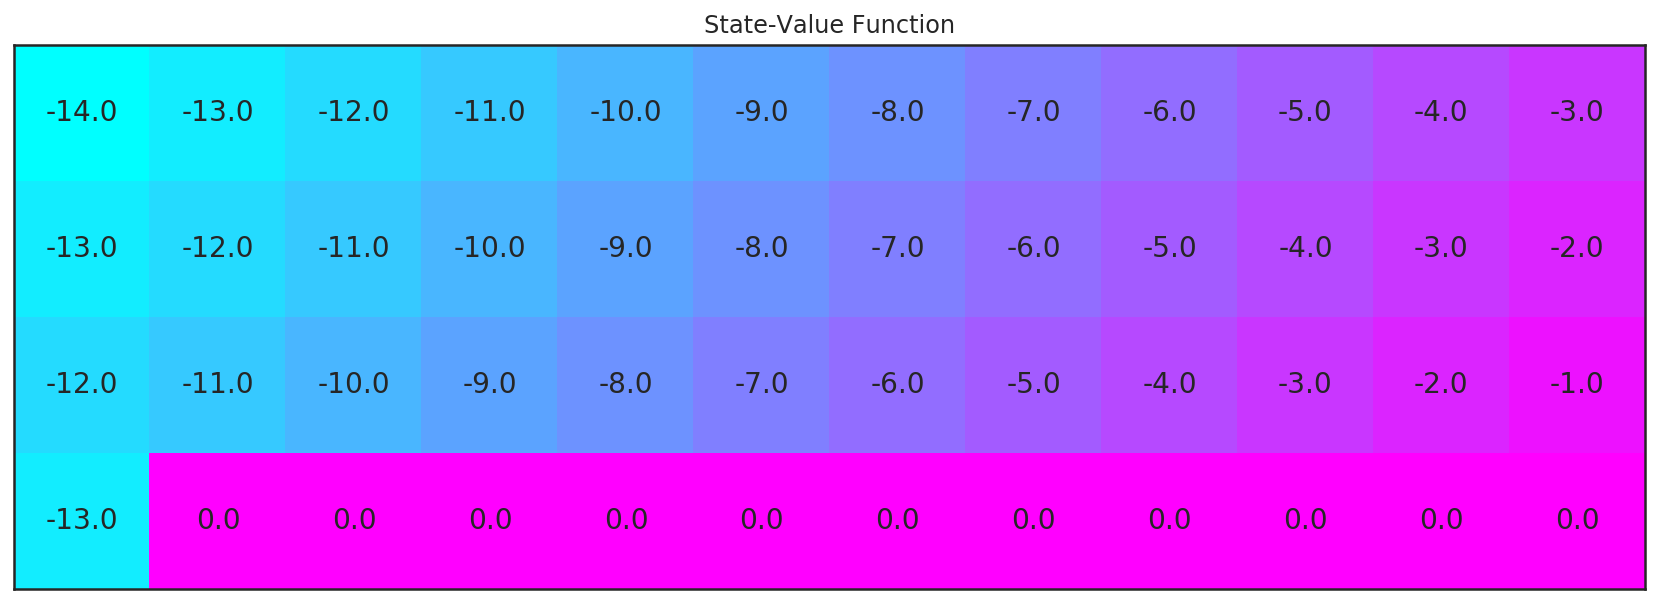

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### TD Control: Sarsa

Implementation of the Sarsa control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [5]:
def eps_greedy(Q_s, nA, i_episode, eps=None):
    epsilon = 1.0 / i_episode
    
    if eps is not None:
        epsilon = eps
    
    policy = np.ones(nA) * (epsilon / nA)
    best_action = np.argmax(Q_s)
    policy[best_action] = 1. - epsilon + (epsilon / nA)
    
    action = np.random.choice(np.arange(nA), p=policy)
    
    return action

def update_Q(Qsa, Qsa_next, reward, alpha, gamma):
    return Qsa + (alpha * (reward + (gamma * Qsa_next) - Qsa))

In [6]:
import matplotlib.pyplot as plt
from collections import deque


def sarsa(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Track performance
    
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):          
        # Observe S0
        
        state = env.reset()
        
        # Choose A0 according to the policy
        
        action = eps_greedy(Q[state], nA, i_episode)
        
        # Initialise score
        
        score = 0
        
        # Limit the number of time steps
        
        for t_step in np.arange(300):
            next_state, reward, done, info = env.step(action)
            
            score += reward
            
            if not done:
                next_action = eps_greedy(Q[next_state], nA, i_episode)

                Q[state][action] = update_Q(Q[state][action],
                                            Q[next_state][next_action],
                                            reward, alpha, gamma)

                state = next_state
                action = next_action
            else:
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                tmp_scores.append(score)
                break
        
        # monitor progress
        
        if i_episode % 100 == 0:
            scores.append(np.mean(tmp_scores))
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
    
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    
    return Q

Visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Episode 5000/5000

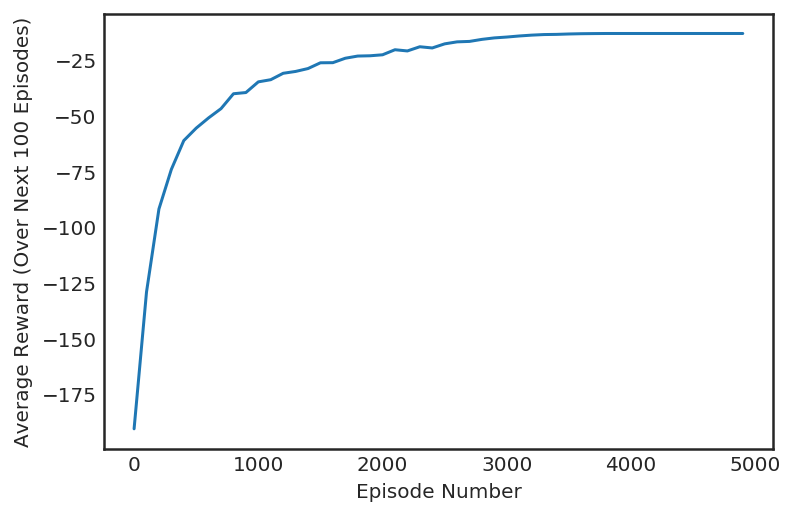

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  3  0  1  1  1  1  0  1  1  2  3]
 [ 0  1  1  3  2  1  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


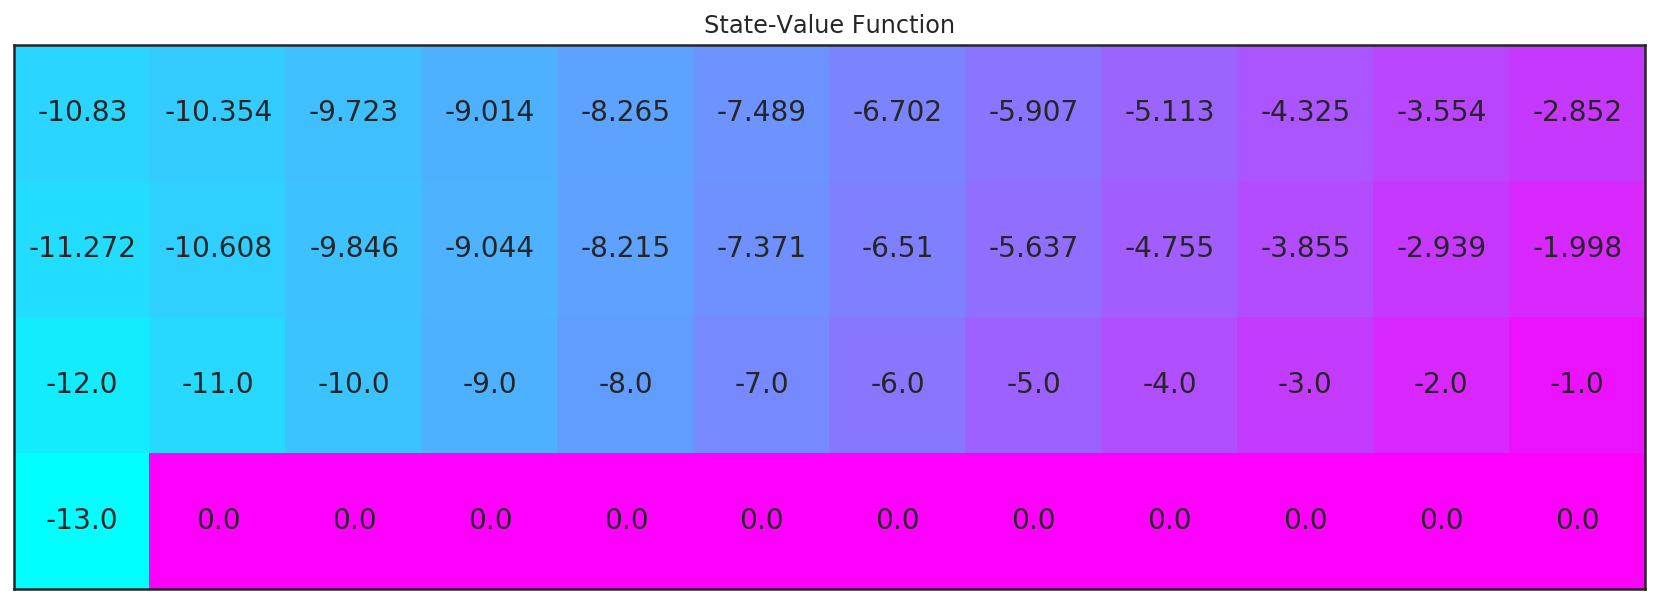

In [7]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### TD Control: Q-learning

Implementation of the Q-learning control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [8]:
def update_Q_sarsamax(Qsa, Qsa_next, reward, alpha, gamma):
    return Qsa + (alpha * (reward + (gamma * np.max(Qsa_next))) - Qsa)

In [9]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    nA = env.nA
    Q = defaultdict(lambda: np.zeros(nA))

    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):        
        ## TODO: complete the function
        
        score = 0
        state = env.reset()
        
        while True:
            # pick next action A
            action = eps_greedy(Q[state], nA, i_episode)
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            # update Q
            Q[state][action] = update_Q(Q[state][action],
                                        np.max(Q[next_state]),
                                        reward, alpha, gamma)
            state = next_state
            # until S is terminal
            if done:
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
        
    return Q

Visualize the **_estimated_** optimal policy and the corresponding state-value function. 

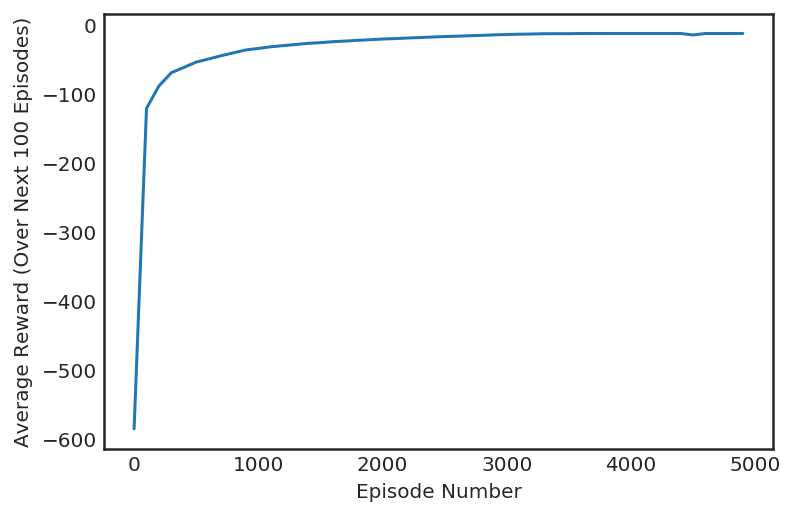

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  0  1  1  1  1  0  1  2]
 [ 1  1  1  1  2  1  0  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


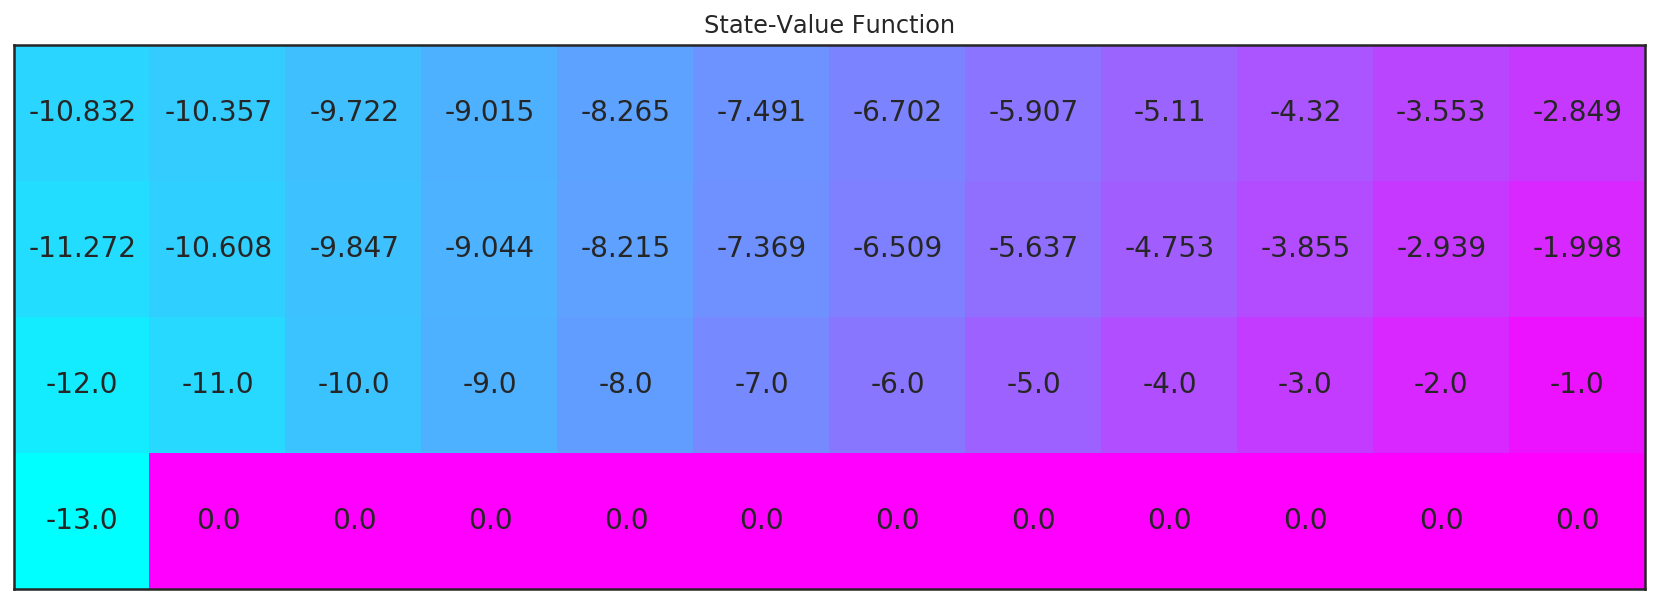

In [10]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### TD Control: Expected Sarsa

Implementation of the Expected Sarsa control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [11]:
def calculate_expected_value(Qs, nA, i_episode, eps=None):
    epsilon = 1.0 / i_episode
    
    if eps is not None:
        epsilon = eps
    
    probs = np.ones(nA) * (epsilon / nA)
    best_action = np.argmax(Qs)
    probs[best_action] = 1.0 - epsilon + (epsilon / nA)
    
    return np.dot(Qs, probs)

In [12]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    nA = env.nA
    Q = defaultdict(lambda: np.zeros(nA))
    
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        
        for t_step in np.arange(300):
            action = eps_greedy(Q[state], nA, i_episode, 0.005)
            next_state, reward, done, info = env.step(action)
            
            score += reward
            
            if not done:
                expected_value = calculate_expected_value(Q[next_state], nA, i_episode, 0.005)
                Q[state][action] = update_Q(Q[state][action],
                                            expected_value, reward, alpha, gamma)
                state = next_state
            else:
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                tmp_scores.append(score)
                break
                
        # monitor progress
        if i_episode % 100 == 0:
            scores.append(np.mean(tmp_scores))
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
    
    x = np.linspace(0, num_episodes, len(scores))
    plt.plot(x, np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
        
    return Q

Visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Episode 10000/10000

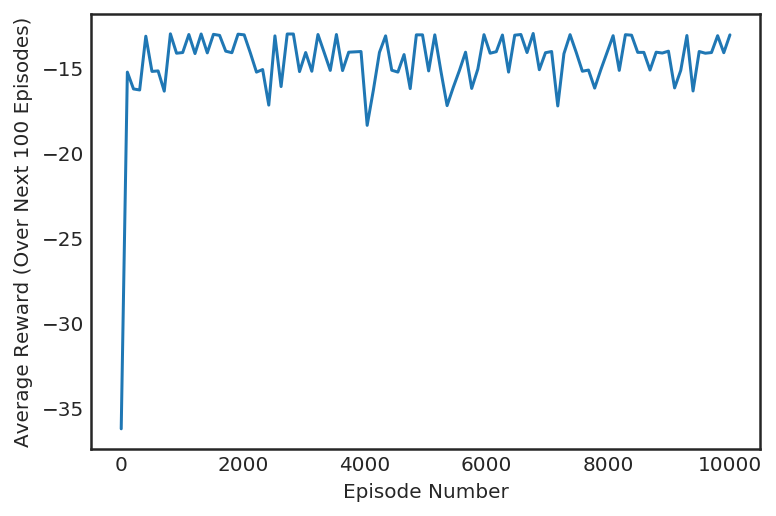

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  3  1  1  1  1  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


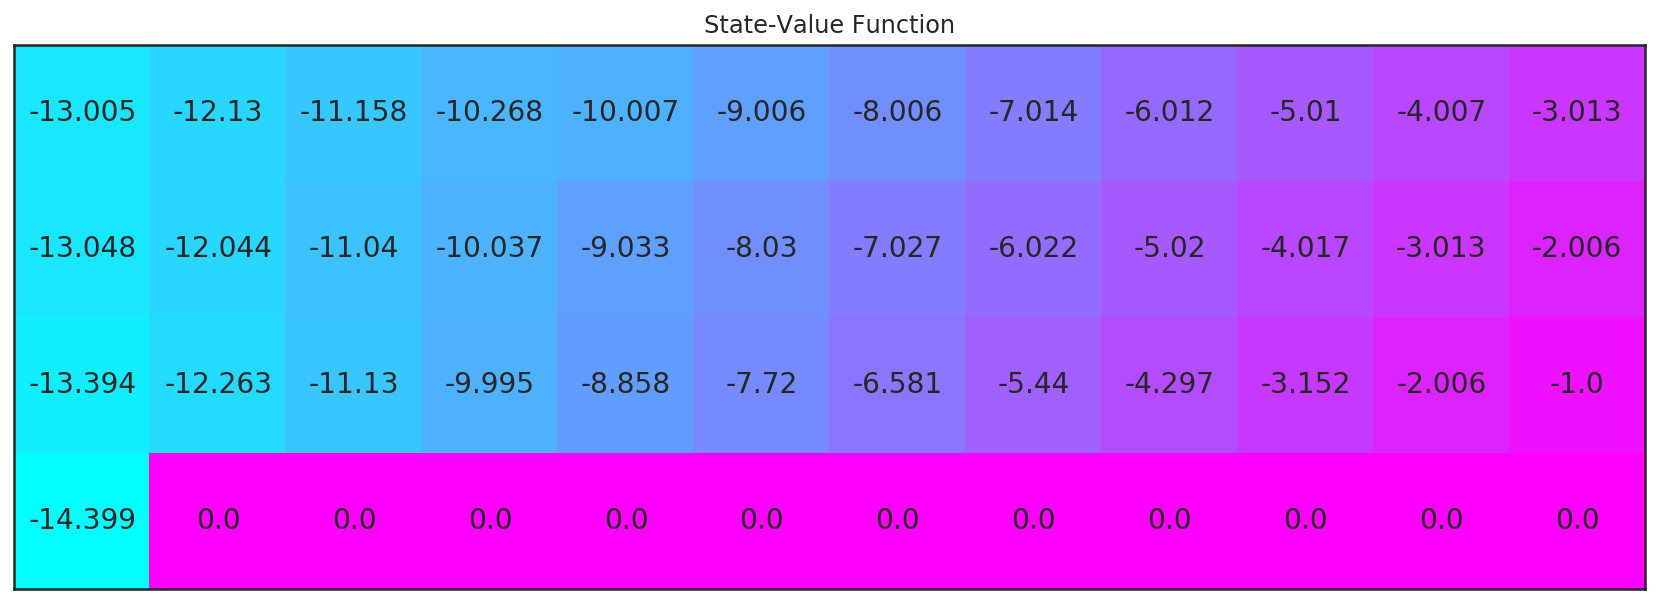

In [13]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])